Script to train Final Model

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout

import os
import random
import gc
import tempfile
from pickle import dump, load

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
from scipy.optimize import fsolve
from math import exp
import shap

random_state = 1234
np.random.seed(random_state)
random.seed(random_state)
tf.random.set_seed(random_state)

## Pre-Defined Parameters

### Display Configuration

In [2]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size':22})

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

### Data Input

In [3]:
# input file
train_file = '../Data/DP_Phase4_combined_v3_train.csv'
test_file = '../Data/DP_Phase4_combined_v3_test.csv'
old_feature_file = '../Data/featurelist_3m.csv'
data2019_file = '../Data/DP_Phase4_2019_ALL.csv'
model_folder = '../saved_model/'
results_folder = '../model_results/'
sample_size = None # set to None if using full dataset


target_col = [
    'Cerebral_Vascular_Accident', 'Diabetes_Mellitus',
    'Dyslipidaemia', 'Heart_and_Circulatory', 'Hypertension',
    'Osteoporosis', 'Renal_Disease', 'Osteoarthritis', 'Deceased'
]

prior_diag_col = ["Cerebral_Vascular_Accident_Diagnosed","Cerebral_Vascular_Accident_Medication",
                  "Cerebral_Vascular_Accident_Test","Diabetes_Mellitus_Diagnosed","Diabetes_Mellitus_Medication",
                  "Diabetes_Mellitus_Test","Dyslipidaemia_Diagnosed","Dyslipidaemia_Medication","Dyslipidaemia_Test",
                  "Heart_and_Circulatory_Diagnosed","Heart_and_Circulatory_Medication","Heart_and_Circulatory_Test",
                  "Hypertension_Diagnosed","Hypertension_Medication","Hypertension_Test","Osteoporosis_Diagnosed",
                  "Osteoporosis_Medication","Osteoporosis_Test","Osteoarthritis_Diagnosed","Osteoarthritis_Medication",
                  "Osteoarthritis_Test","Renal_Disease_Diagnosed","Renal_Disease_Medication","Renal_Disease_Test",
                  "Deceased_Diagnosed","Deceased_Medication","Deceased_Test"
]

prior_diag_drop = ["Cerebral_Vascular_Accident_Test", "Cerebral_Vascular_Accident_Medication",
                  "Heart_and_Circulatory_Medication", "Heart_and_Circulatory_Test",
                  "Hypertension_Test",
                  "Osteoporosis_Test",
                  "Osteoarthritis_Medication", "Osteoarthritis_Test",
                  "Renal_Disease_Medication",
                  "Deceased_Diagnosed","Deceased_Medication","Deceased_Test"
]

target_prior_col = [target+'_Prior' for target in target_col[:-1]]

# SHAP parameters
non_periodic_features = ['PAT_AGE', 'GENDER_Male', 'GENDER_Female', 
                         'RACE_Chinese', 'RACE_Malay', 'RACE_Indian', 'RACE_Others',
                         "Cancer_Prior","Cerebral_Vascular_Accident_Prior","Diabetes_Mellitus_Prior",
                         "Dyslipidaemia_Prior","Heart_and_Circulatory_Prior","Hypertension_Prior",
                         "Osteoporosis_Prior","Renal_Disease_Prior","OverWeight_Prior",
                         "Osteoarthritis_Prior","BPH_Prior","COPD_Prior","Epilepsy_Prior","HepB_Prior",
                         "Parkinson_Prior","Psoriasis_Prior","RA_Prior","Allergic_Prior","Asthma_Prior",
                         "Dementia_Prior","Gout_Prior"
] + prior_diag_col

# features to drop
feature_to_drop = ['PAT_ID'] + target_col + target_prior_col

# validation data size
val_size=60800

In [4]:
count_cols = [
'YEARH_NUM_UNQ_ATCL2_A01', 'YEAR1_NUM_UNQ_ATCL2_A01', 'YEAR1H_NUM_UNQ_ATCL2_A01', 'YEAR2_NUM_UNQ_ATCL2_A01', 'YEAR2H_NUM_UNQ_ATCL2_A01', 'YEAR3_NUM_UNQ_ATCL2_A01',
'YEARH_NUM_UNQ_ATCL2_A02', 'YEAR1_NUM_UNQ_ATCL2_A02', 'YEAR1H_NUM_UNQ_ATCL2_A02', 'YEAR2_NUM_UNQ_ATCL2_A02', 'YEAR2H_NUM_UNQ_ATCL2_A02', 'YEAR3_NUM_UNQ_ATCL2_A02',
'YEARH_NUM_UNQ_ATCL2_A03', 'YEAR1_NUM_UNQ_ATCL2_A03', 'YEAR1H_NUM_UNQ_ATCL2_A03', 'YEAR2_NUM_UNQ_ATCL2_A03', 'YEAR2H_NUM_UNQ_ATCL2_A03', 'YEAR3_NUM_UNQ_ATCL2_A03',
'YEARH_NUM_UNQ_ATCL2_A04', 'YEAR1_NUM_UNQ_ATCL2_A04', 'YEAR1H_NUM_UNQ_ATCL2_A04', 'YEAR2_NUM_UNQ_ATCL2_A04', 'YEAR2H_NUM_UNQ_ATCL2_A04', 'YEAR3_NUM_UNQ_ATCL2_A04',
'YEARH_NUM_UNQ_ATCL2_A06', 'YEAR1_NUM_UNQ_ATCL2_A06', 'YEAR1H_NUM_UNQ_ATCL2_A06', 'YEAR2_NUM_UNQ_ATCL2_A06', 'YEAR2H_NUM_UNQ_ATCL2_A06', 'YEAR3_NUM_UNQ_ATCL2_A06',
'YEARH_NUM_UNQ_ATCL2_A07', 'YEAR1_NUM_UNQ_ATCL2_A07', 'YEAR1H_NUM_UNQ_ATCL2_A07', 'YEAR2_NUM_UNQ_ATCL2_A07', 'YEAR2H_NUM_UNQ_ATCL2_A07', 'YEAR3_NUM_UNQ_ATCL2_A07',
'YEARH_NUM_UNQ_ATCL2_A10', 'YEAR1_NUM_UNQ_ATCL2_A10', 'YEAR1H_NUM_UNQ_ATCL2_A10', 'YEAR2_NUM_UNQ_ATCL2_A10', 'YEAR2H_NUM_UNQ_ATCL2_A10', 'YEAR3_NUM_UNQ_ATCL2_A10',
'YEARH_NUM_UNQ_ATCL2_A11', 'YEAR1_NUM_UNQ_ATCL2_A11', 'YEAR1H_NUM_UNQ_ATCL2_A11', 'YEAR2_NUM_UNQ_ATCL2_A11', 'YEAR2H_NUM_UNQ_ATCL2_A11', 'YEAR3_NUM_UNQ_ATCL2_A11',
'YEARH_NUM_UNQ_ATCL2_A12', 'YEAR1_NUM_UNQ_ATCL2_A12', 'YEAR1H_NUM_UNQ_ATCL2_A12', 'YEAR2_NUM_UNQ_ATCL2_A12', 'YEAR2H_NUM_UNQ_ATCL2_A12', 'YEAR3_NUM_UNQ_ATCL2_A12',
'YEARH_NUM_UNQ_ATCL2_B01', 'YEAR1_NUM_UNQ_ATCL2_B01', 'YEAR1H_NUM_UNQ_ATCL2_B01', 'YEAR2_NUM_UNQ_ATCL2_B01', 'YEAR2H_NUM_UNQ_ATCL2_B01', 'YEAR3_NUM_UNQ_ATCL2_B01',
'YEARH_NUM_UNQ_ATCL2_B02', 'YEAR1_NUM_UNQ_ATCL2_B02', 'YEAR1H_NUM_UNQ_ATCL2_B02', 'YEAR2_NUM_UNQ_ATCL2_B02', 'YEAR2H_NUM_UNQ_ATCL2_B02', 'YEAR3_NUM_UNQ_ATCL2_B02',
'YEARH_NUM_UNQ_ATCL2_B03', 'YEAR1_NUM_UNQ_ATCL2_B03', 'YEAR1H_NUM_UNQ_ATCL2_B03', 'YEAR2_NUM_UNQ_ATCL2_B03', 'YEAR2H_NUM_UNQ_ATCL2_B03', 'YEAR3_NUM_UNQ_ATCL2_B03',
'YEARH_NUM_UNQ_ATCL2_B05', 'YEAR1_NUM_UNQ_ATCL2_B05', 'YEAR1H_NUM_UNQ_ATCL2_B05', 'YEAR2_NUM_UNQ_ATCL2_B05', 'YEAR2H_NUM_UNQ_ATCL2_B05', 'YEAR3_NUM_UNQ_ATCL2_B05',
'YEARH_NUM_UNQ_ATCL2_C01', 'YEAR1_NUM_UNQ_ATCL2_C01', 'YEAR1H_NUM_UNQ_ATCL2_C01', 'YEAR2_NUM_UNQ_ATCL2_C01', 'YEAR2H_NUM_UNQ_ATCL2_C01', 'YEAR3_NUM_UNQ_ATCL2_C01',
'YEARH_NUM_UNQ_ATCL2_C02', 'YEAR1_NUM_UNQ_ATCL2_C02', 'YEAR1H_NUM_UNQ_ATCL2_C02', 'YEAR2_NUM_UNQ_ATCL2_C02', 'YEAR2H_NUM_UNQ_ATCL2_C02', 'YEAR3_NUM_UNQ_ATCL2_C02',
'YEARH_NUM_UNQ_ATCL2_C03', 'YEAR1_NUM_UNQ_ATCL2_C03', 'YEAR1H_NUM_UNQ_ATCL2_C03', 'YEAR2_NUM_UNQ_ATCL2_C03', 'YEAR2H_NUM_UNQ_ATCL2_C03', 'YEAR3_NUM_UNQ_ATCL2_C03',
'YEARH_NUM_UNQ_ATCL2_C04', 'YEAR1_NUM_UNQ_ATCL2_C04', 'YEAR1H_NUM_UNQ_ATCL2_C04', 'YEAR2_NUM_UNQ_ATCL2_C04', 'YEAR2H_NUM_UNQ_ATCL2_C04', 'YEAR3_NUM_UNQ_ATCL2_C04',
'YEARH_NUM_UNQ_ATCL2_C05', 'YEAR1_NUM_UNQ_ATCL2_C05', 'YEAR1H_NUM_UNQ_ATCL2_C05', 'YEAR2_NUM_UNQ_ATCL2_C05', 'YEAR2H_NUM_UNQ_ATCL2_C05', 'YEAR3_NUM_UNQ_ATCL2_C05',
'YEARH_NUM_UNQ_ATCL2_C07', 'YEAR1_NUM_UNQ_ATCL2_C07', 'YEAR1H_NUM_UNQ_ATCL2_C07', 'YEAR2_NUM_UNQ_ATCL2_C07', 'YEAR2H_NUM_UNQ_ATCL2_C07', 'YEAR3_NUM_UNQ_ATCL2_C07',
'YEARH_NUM_UNQ_ATCL2_C08', 'YEAR1_NUM_UNQ_ATCL2_C08', 'YEAR1H_NUM_UNQ_ATCL2_C08', 'YEAR2_NUM_UNQ_ATCL2_C08', 'YEAR2H_NUM_UNQ_ATCL2_C08', 'YEAR3_NUM_UNQ_ATCL2_C08',
'YEARH_NUM_UNQ_ATCL2_C09', 'YEAR1_NUM_UNQ_ATCL2_C09', 'YEAR1H_NUM_UNQ_ATCL2_C09', 'YEAR2_NUM_UNQ_ATCL2_C09', 'YEAR2H_NUM_UNQ_ATCL2_C09', 'YEAR3_NUM_UNQ_ATCL2_C09',
'YEARH_NUM_UNQ_ATCL2_C10', 'YEAR1_NUM_UNQ_ATCL2_C10', 'YEAR1H_NUM_UNQ_ATCL2_C10', 'YEAR2_NUM_UNQ_ATCL2_C10', 'YEAR2H_NUM_UNQ_ATCL2_C10', 'YEAR3_NUM_UNQ_ATCL2_C10',
'YEARH_NUM_UNQ_ATCL2_D01', 'YEAR1_NUM_UNQ_ATCL2_D01', 'YEAR1H_NUM_UNQ_ATCL2_D01', 'YEAR2_NUM_UNQ_ATCL2_D01', 'YEAR2H_NUM_UNQ_ATCL2_D01', 'YEAR3_NUM_UNQ_ATCL2_D01',
'YEARH_NUM_UNQ_ATCL2_D02', 'YEAR1_NUM_UNQ_ATCL2_D02', 'YEAR1H_NUM_UNQ_ATCL2_D02', 'YEAR2_NUM_UNQ_ATCL2_D02', 'YEAR2H_NUM_UNQ_ATCL2_D02', 'YEAR3_NUM_UNQ_ATCL2_D02',
'YEARH_NUM_UNQ_ATCL2_D04', 'YEAR1_NUM_UNQ_ATCL2_D04', 'YEAR1H_NUM_UNQ_ATCL2_D04', 'YEAR2_NUM_UNQ_ATCL2_D04', 'YEAR2H_NUM_UNQ_ATCL2_D04', 'YEAR3_NUM_UNQ_ATCL2_D04',
'YEARH_NUM_UNQ_ATCL2_D06', 'YEAR1_NUM_UNQ_ATCL2_D06', 'YEAR1H_NUM_UNQ_ATCL2_D06', 'YEAR2_NUM_UNQ_ATCL2_D06', 'YEAR2H_NUM_UNQ_ATCL2_D06', 'YEAR3_NUM_UNQ_ATCL2_D06',
'YEARH_NUM_UNQ_ATCL2_D08', 'YEAR1_NUM_UNQ_ATCL2_D08', 'YEAR1H_NUM_UNQ_ATCL2_D08', 'YEAR2_NUM_UNQ_ATCL2_D08', 'YEAR2H_NUM_UNQ_ATCL2_D08', 'YEAR3_NUM_UNQ_ATCL2_D08',
'YEARH_NUM_UNQ_ATCL2_D11', 'YEAR1_NUM_UNQ_ATCL2_D11', 'YEAR1H_NUM_UNQ_ATCL2_D11', 'YEAR2_NUM_UNQ_ATCL2_D11', 'YEAR2H_NUM_UNQ_ATCL2_D11', 'YEAR3_NUM_UNQ_ATCL2_D11',
'YEARH_NUM_UNQ_ATCL2_G01', 'YEAR1_NUM_UNQ_ATCL2_G01', 'YEAR1H_NUM_UNQ_ATCL2_G01', 'YEAR2_NUM_UNQ_ATCL2_G01', 'YEAR2H_NUM_UNQ_ATCL2_G01', 'YEAR3_NUM_UNQ_ATCL2_G01',
'YEARH_NUM_UNQ_ATCL2_G03', 'YEAR1_NUM_UNQ_ATCL2_G03', 'YEAR1H_NUM_UNQ_ATCL2_G03', 'YEAR2_NUM_UNQ_ATCL2_G03', 'YEAR2H_NUM_UNQ_ATCL2_G03', 'YEAR3_NUM_UNQ_ATCL2_G03',
'YEARH_NUM_UNQ_ATCL2_G04', 'YEAR1_NUM_UNQ_ATCL2_G04', 'YEAR1H_NUM_UNQ_ATCL2_G04', 'YEAR2_NUM_UNQ_ATCL2_G04', 'YEAR2H_NUM_UNQ_ATCL2_G04', 'YEAR3_NUM_UNQ_ATCL2_G04',
'YEARH_NUM_UNQ_ATCL2_H01', 'YEAR1_NUM_UNQ_ATCL2_H01', 'YEAR1H_NUM_UNQ_ATCL2_H01', 'YEAR2_NUM_UNQ_ATCL2_H01', 'YEAR2H_NUM_UNQ_ATCL2_H01', 'YEAR3_NUM_UNQ_ATCL2_H01',
'YEARH_NUM_UNQ_ATCL2_H02', 'YEAR1_NUM_UNQ_ATCL2_H02', 'YEAR1H_NUM_UNQ_ATCL2_H02', 'YEAR2_NUM_UNQ_ATCL2_H02', 'YEAR2H_NUM_UNQ_ATCL2_H02', 'YEAR3_NUM_UNQ_ATCL2_H02',
'YEARH_NUM_UNQ_ATCL2_H03', 'YEAR1_NUM_UNQ_ATCL2_H03', 'YEAR1H_NUM_UNQ_ATCL2_H03', 'YEAR2_NUM_UNQ_ATCL2_H03', 'YEAR2H_NUM_UNQ_ATCL2_H03', 'YEAR3_NUM_UNQ_ATCL2_H03',
'YEARH_NUM_UNQ_ATCL2_H05', 'YEAR1_NUM_UNQ_ATCL2_H05', 'YEAR1H_NUM_UNQ_ATCL2_H05', 'YEAR2_NUM_UNQ_ATCL2_H05', 'YEAR2H_NUM_UNQ_ATCL2_H05', 'YEAR3_NUM_UNQ_ATCL2_H05',
'YEARH_NUM_UNQ_ATCL2_L01', 'YEAR1_NUM_UNQ_ATCL2_L01', 'YEAR1H_NUM_UNQ_ATCL2_L01', 'YEAR2_NUM_UNQ_ATCL2_L01', 'YEAR2H_NUM_UNQ_ATCL2_L01', 'YEAR3_NUM_UNQ_ATCL2_L01',
'YEARH_NUM_UNQ_ATCL2_L02', 'YEAR1_NUM_UNQ_ATCL2_L02', 'YEAR1H_NUM_UNQ_ATCL2_L02', 'YEAR2_NUM_UNQ_ATCL2_L02', 'YEAR2H_NUM_UNQ_ATCL2_L02', 'YEAR3_NUM_UNQ_ATCL2_L02',
'YEARH_NUM_UNQ_ATCL2_L04', 'YEAR1_NUM_UNQ_ATCL2_L04', 'YEAR1H_NUM_UNQ_ATCL2_L04', 'YEAR2_NUM_UNQ_ATCL2_L04', 'YEAR2H_NUM_UNQ_ATCL2_L04', 'YEAR3_NUM_UNQ_ATCL2_L04',
'YEARH_NUM_UNQ_ATCL2_M01', 'YEAR1_NUM_UNQ_ATCL2_M01', 'YEAR1H_NUM_UNQ_ATCL2_M01', 'YEAR2_NUM_UNQ_ATCL2_M01', 'YEAR2H_NUM_UNQ_ATCL2_M01', 'YEAR3_NUM_UNQ_ATCL2_M01',
'YEARH_NUM_UNQ_ATCL2_M02', 'YEAR1_NUM_UNQ_ATCL2_M02', 'YEAR1H_NUM_UNQ_ATCL2_M02', 'YEAR2_NUM_UNQ_ATCL2_M02', 'YEAR2H_NUM_UNQ_ATCL2_M02', 'YEAR3_NUM_UNQ_ATCL2_M02',
'YEARH_NUM_UNQ_ATCL2_M03', 'YEAR1_NUM_UNQ_ATCL2_M03', 'YEAR1H_NUM_UNQ_ATCL2_M03', 'YEAR2_NUM_UNQ_ATCL2_M03', 'YEAR2H_NUM_UNQ_ATCL2_M03', 'YEAR3_NUM_UNQ_ATCL2_M03',
'YEARH_NUM_UNQ_ATCL2_M04', 'YEAR1_NUM_UNQ_ATCL2_M04', 'YEAR1H_NUM_UNQ_ATCL2_M04', 'YEAR2_NUM_UNQ_ATCL2_M04', 'YEAR2H_NUM_UNQ_ATCL2_M04', 'YEAR3_NUM_UNQ_ATCL2_M04',
'YEARH_NUM_UNQ_ATCL2_M05', 'YEAR1_NUM_UNQ_ATCL2_M05', 'YEAR1H_NUM_UNQ_ATCL2_M05', 'YEAR2_NUM_UNQ_ATCL2_M05', 'YEAR2H_NUM_UNQ_ATCL2_M05', 'YEAR3_NUM_UNQ_ATCL2_M05',
'YEARH_NUM_UNQ_ATCL2_N02', 'YEAR1_NUM_UNQ_ATCL2_N02', 'YEAR1H_NUM_UNQ_ATCL2_N02', 'YEAR2_NUM_UNQ_ATCL2_N02', 'YEAR2H_NUM_UNQ_ATCL2_N02', 'YEAR3_NUM_UNQ_ATCL2_N02',
'YEARH_NUM_UNQ_ATCL2_N03', 'YEAR1_NUM_UNQ_ATCL2_N03', 'YEAR1H_NUM_UNQ_ATCL2_N03', 'YEAR2_NUM_UNQ_ATCL2_N03', 'YEAR2H_NUM_UNQ_ATCL2_N03', 'YEAR3_NUM_UNQ_ATCL2_N03',
'YEARH_NUM_UNQ_ATCL2_N04', 'YEAR1_NUM_UNQ_ATCL2_N04', 'YEAR1H_NUM_UNQ_ATCL2_N04', 'YEAR2_NUM_UNQ_ATCL2_N04', 'YEAR2H_NUM_UNQ_ATCL2_N04', 'YEAR3_NUM_UNQ_ATCL2_N04',
'YEARH_NUM_UNQ_ATCL2_N05', 'YEAR1_NUM_UNQ_ATCL2_N05', 'YEAR1H_NUM_UNQ_ATCL2_N05', 'YEAR2_NUM_UNQ_ATCL2_N05', 'YEAR2H_NUM_UNQ_ATCL2_N05', 'YEAR3_NUM_UNQ_ATCL2_N05',
'YEARH_NUM_UNQ_ATCL2_N06', 'YEAR1_NUM_UNQ_ATCL2_N06', 'YEAR1H_NUM_UNQ_ATCL2_N06', 'YEAR2_NUM_UNQ_ATCL2_N06', 'YEAR2H_NUM_UNQ_ATCL2_N06', 'YEAR3_NUM_UNQ_ATCL2_N06',
'YEARH_NUM_UNQ_ATCL2_R01', 'YEAR1_NUM_UNQ_ATCL2_R01', 'YEAR1H_NUM_UNQ_ATCL2_R01', 'YEAR2_NUM_UNQ_ATCL2_R01', 'YEAR2H_NUM_UNQ_ATCL2_R01', 'YEAR3_NUM_UNQ_ATCL2_R01',
'YEARH_NUM_UNQ_ATCL2_R02', 'YEAR1_NUM_UNQ_ATCL2_R02', 'YEAR1H_NUM_UNQ_ATCL2_R02', 'YEAR2_NUM_UNQ_ATCL2_R02', 'YEAR2H_NUM_UNQ_ATCL2_R02', 'YEAR3_NUM_UNQ_ATCL2_R02',
'YEARH_NUM_UNQ_ATCL2_R03', 'YEAR1_NUM_UNQ_ATCL2_R03', 'YEAR1H_NUM_UNQ_ATCL2_R03', 'YEAR2_NUM_UNQ_ATCL2_R03', 'YEAR2H_NUM_UNQ_ATCL2_R03', 'YEAR3_NUM_UNQ_ATCL2_R03',
'YEARH_NUM_UNQ_ATCL2_R05', 'YEAR1_NUM_UNQ_ATCL2_R05', 'YEAR1H_NUM_UNQ_ATCL2_R05', 'YEAR2_NUM_UNQ_ATCL2_R05', 'YEAR2H_NUM_UNQ_ATCL2_R05', 'YEAR3_NUM_UNQ_ATCL2_R05',
'YEARH_NUM_UNQ_ATCL2_R06', 'YEAR1_NUM_UNQ_ATCL2_R06', 'YEAR1H_NUM_UNQ_ATCL2_R06', 'YEAR2_NUM_UNQ_ATCL2_R06', 'YEAR2H_NUM_UNQ_ATCL2_R06', 'YEAR3_NUM_UNQ_ATCL2_R06',
'YEARH_NUM_UNQ_ATCL2_S01', 'YEAR1_NUM_UNQ_ATCL2_S01', 'YEAR1H_NUM_UNQ_ATCL2_S01', 'YEAR2_NUM_UNQ_ATCL2_S01', 'YEAR2H_NUM_UNQ_ATCL2_S01', 'YEAR3_NUM_UNQ_ATCL2_S01',
'YEARH_NUM_UNQ_ATCL2_S03', 'YEAR1_NUM_UNQ_ATCL2_S03', 'YEAR1H_NUM_UNQ_ATCL2_S03', 'YEAR2_NUM_UNQ_ATCL2_S03', 'YEAR2H_NUM_UNQ_ATCL2_S03', 'YEAR3_NUM_UNQ_ATCL2_S03',
'YEARH_UNQ_SUBCHAPTER_blood1', 'YEAR1_UNQ_SUBCHAPTER_blood1', 'YEAR1H_UNQ_SUBCHAPTER_blood1', 'YEAR2_UNQ_SUBCHAPTER_blood1', 'YEAR2H_UNQ_SUBCHAPTER_blood1', 'YEAR3_UNQ_SUBCHAPTER_blood1',
'YEARH_UNQ_SUBCHAPTER_blood2', 'YEAR1_UNQ_SUBCHAPTER_blood2', 'YEAR1H_UNQ_SUBCHAPTER_blood2', 'YEAR2_UNQ_SUBCHAPTER_blood2', 'YEAR2H_UNQ_SUBCHAPTER_blood2', 'YEAR3_UNQ_SUBCHAPTER_blood2',
'YEARH_UNQ_SUBCHAPTER_circulatory3', 'YEAR1_UNQ_SUBCHAPTER_circulatory3', 'YEAR1H_UNQ_SUBCHAPTER_circulatory3', 'YEAR2_UNQ_SUBCHAPTER_circulatory3', 'YEAR2H_UNQ_SUBCHAPTER_circulatory3', 'YEAR3_UNQ_SUBCHAPTER_circulatory3',
'YEARH_UNQ_SUBCHAPTER_circulatory4', 'YEAR1_UNQ_SUBCHAPTER_circulatory4', 'YEAR1H_UNQ_SUBCHAPTER_circulatory4', 'YEAR2_UNQ_SUBCHAPTER_circulatory4', 'YEAR2H_UNQ_SUBCHAPTER_circulatory4', 'YEAR3_UNQ_SUBCHAPTER_circulatory4',
'YEARH_UNQ_SUBCHAPTER_circulatory5', 'YEAR1_UNQ_SUBCHAPTER_circulatory5', 'YEAR1H_UNQ_SUBCHAPTER_circulatory5', 'YEAR2_UNQ_SUBCHAPTER_circulatory5', 'YEAR2H_UNQ_SUBCHAPTER_circulatory5', 'YEAR3_UNQ_SUBCHAPTER_circulatory5',
'YEARH_UNQ_SUBCHAPTER_circulatory6', 'YEAR1_UNQ_SUBCHAPTER_circulatory6', 'YEAR1H_UNQ_SUBCHAPTER_circulatory6', 'YEAR2_UNQ_SUBCHAPTER_circulatory6', 'YEAR2H_UNQ_SUBCHAPTER_circulatory6', 'YEAR3_UNQ_SUBCHAPTER_circulatory6',
'YEARH_UNQ_SUBCHAPTER_circulatory7', 'YEAR1_UNQ_SUBCHAPTER_circulatory7', 'YEAR1H_UNQ_SUBCHAPTER_circulatory7', 'YEAR2_UNQ_SUBCHAPTER_circulatory7', 'YEAR2H_UNQ_SUBCHAPTER_circulatory7', 'YEAR3_UNQ_SUBCHAPTER_circulatory7',
'YEARH_UNQ_SUBCHAPTER_circulatory8', 'YEAR1_UNQ_SUBCHAPTER_circulatory8', 'YEAR1H_UNQ_SUBCHAPTER_circulatory8', 'YEAR2_UNQ_SUBCHAPTER_circulatory8', 'YEAR2H_UNQ_SUBCHAPTER_circulatory8', 'YEAR3_UNQ_SUBCHAPTER_circulatory8',
'YEARH_UNQ_SUBCHAPTER_circulatory9', 'YEAR1_UNQ_SUBCHAPTER_circulatory9', 'YEAR1H_UNQ_SUBCHAPTER_circulatory9', 'YEAR2_UNQ_SUBCHAPTER_circulatory9', 'YEAR2H_UNQ_SUBCHAPTER_circulatory9', 'YEAR3_UNQ_SUBCHAPTER_circulatory9',
'YEARH_UNQ_SUBCHAPTER_digestive2', 'YEAR1_UNQ_SUBCHAPTER_digestive2', 'YEAR1H_UNQ_SUBCHAPTER_digestive2', 'YEAR2_UNQ_SUBCHAPTER_digestive2', 'YEAR2H_UNQ_SUBCHAPTER_digestive2', 'YEAR3_UNQ_SUBCHAPTER_digestive2',
'YEARH_UNQ_SUBCHAPTER_digestive5', 'YEAR1_UNQ_SUBCHAPTER_digestive5', 'YEAR1H_UNQ_SUBCHAPTER_digestive5', 'YEAR2_UNQ_SUBCHAPTER_digestive5', 'YEAR2H_UNQ_SUBCHAPTER_digestive5', 'YEAR3_UNQ_SUBCHAPTER_digestive5',
'YEARH_UNQ_SUBCHAPTER_digestive6', 'YEAR1_UNQ_SUBCHAPTER_digestive6', 'YEAR1H_UNQ_SUBCHAPTER_digestive6', 'YEAR2_UNQ_SUBCHAPTER_digestive6', 'YEAR2H_UNQ_SUBCHAPTER_digestive6', 'YEAR3_UNQ_SUBCHAPTER_digestive6',
'YEARH_UNQ_SUBCHAPTER_digestive7', 'YEAR1_UNQ_SUBCHAPTER_digestive7', 'YEAR1H_UNQ_SUBCHAPTER_digestive7', 'YEAR2_UNQ_SUBCHAPTER_digestive7', 'YEAR2H_UNQ_SUBCHAPTER_digestive7', 'YEAR3_UNQ_SUBCHAPTER_digestive7',
'YEARH_UNQ_SUBCHAPTER_genitourinary1', 'YEAR1_UNQ_SUBCHAPTER_genitourinary1', 'YEAR1H_UNQ_SUBCHAPTER_genitourinary1', 'YEAR2_UNQ_SUBCHAPTER_genitourinary1', 'YEAR2H_UNQ_SUBCHAPTER_genitourinary1', 'YEAR3_UNQ_SUBCHAPTER_genitourinary1',
'YEARH_UNQ_SUBCHAPTER_genitourinary2', 'YEAR1_UNQ_SUBCHAPTER_genitourinary2', 'YEAR1H_UNQ_SUBCHAPTER_genitourinary2', 'YEAR2_UNQ_SUBCHAPTER_genitourinary2', 'YEAR2H_UNQ_SUBCHAPTER_genitourinary2', 'YEAR3_UNQ_SUBCHAPTER_genitourinary2',
'YEARH_UNQ_SUBCHAPTER_genitourinary3', 'YEAR1_UNQ_SUBCHAPTER_genitourinary3', 'YEAR1H_UNQ_SUBCHAPTER_genitourinary3', 'YEAR2_UNQ_SUBCHAPTER_genitourinary3', 'YEAR2H_UNQ_SUBCHAPTER_genitourinary3', 'YEAR3_UNQ_SUBCHAPTER_genitourinary3',
'YEARH_UNQ_SUBCHAPTER_genitourinary4', 'YEAR1_UNQ_SUBCHAPTER_genitourinary4', 'YEAR1H_UNQ_SUBCHAPTER_genitourinary4', 'YEAR2_UNQ_SUBCHAPTER_genitourinary4', 'YEAR2H_UNQ_SUBCHAPTER_genitourinary4', 'YEAR3_UNQ_SUBCHAPTER_genitourinary4',
'YEARH_UNQ_SUBCHAPTER_genitourinary6', 'YEAR1_UNQ_SUBCHAPTER_genitourinary6', 'YEAR1H_UNQ_SUBCHAPTER_genitourinary6', 'YEAR2_UNQ_SUBCHAPTER_genitourinary6', 'YEAR2H_UNQ_SUBCHAPTER_genitourinary6', 'YEAR3_UNQ_SUBCHAPTER_genitourinary6',
'YEARH_UNQ_SUBCHAPTER_metabolic1', 'YEAR1_UNQ_SUBCHAPTER_metabolic1', 'YEAR1H_UNQ_SUBCHAPTER_metabolic1', 'YEAR2_UNQ_SUBCHAPTER_metabolic1', 'YEAR2H_UNQ_SUBCHAPTER_metabolic1', 'YEAR3_UNQ_SUBCHAPTER_metabolic1',
'YEARH_UNQ_SUBCHAPTER_metabolic2', 'YEAR1_UNQ_SUBCHAPTER_metabolic2', 'YEAR1H_UNQ_SUBCHAPTER_metabolic2', 'YEAR2_UNQ_SUBCHAPTER_metabolic2', 'YEAR2H_UNQ_SUBCHAPTER_metabolic2', 'YEAR3_UNQ_SUBCHAPTER_metabolic2',
'YEARH_UNQ_SUBCHAPTER_metabolic3', 'YEAR1_UNQ_SUBCHAPTER_metabolic3', 'YEAR1H_UNQ_SUBCHAPTER_metabolic3', 'YEAR2_UNQ_SUBCHAPTER_metabolic3', 'YEAR2H_UNQ_SUBCHAPTER_metabolic3', 'YEAR3_UNQ_SUBCHAPTER_metabolic3',
'YEARH_UNQ_SUBCHAPTER_metabolic4', 'YEAR1_UNQ_SUBCHAPTER_metabolic4', 'YEAR1H_UNQ_SUBCHAPTER_metabolic4', 'YEAR2_UNQ_SUBCHAPTER_metabolic4', 'YEAR2H_UNQ_SUBCHAPTER_metabolic4', 'YEAR3_UNQ_SUBCHAPTER_metabolic4',
'YEARH_UNQ_SUBCHAPTER_musculoskeletal1', 'YEAR1_UNQ_SUBCHAPTER_musculoskeletal1', 'YEAR1H_UNQ_SUBCHAPTER_musculoskeletal1', 'YEAR2_UNQ_SUBCHAPTER_musculoskeletal1', 'YEAR2H_UNQ_SUBCHAPTER_musculoskeletal1', 'YEAR3_UNQ_SUBCHAPTER_musculoskeletal1',
'YEARH_UNQ_SUBCHAPTER_musculoskeletal2', 'YEAR1_UNQ_SUBCHAPTER_musculoskeletal2', 'YEAR1H_UNQ_SUBCHAPTER_musculoskeletal2', 'YEAR2_UNQ_SUBCHAPTER_musculoskeletal2', 'YEAR2H_UNQ_SUBCHAPTER_musculoskeletal2', 'YEAR3_UNQ_SUBCHAPTER_musculoskeletal2',
'YEARH_UNQ_SUBCHAPTER_musculoskeletal3', 'YEAR1_UNQ_SUBCHAPTER_musculoskeletal3', 'YEAR1H_UNQ_SUBCHAPTER_musculoskeletal3', 'YEAR2_UNQ_SUBCHAPTER_musculoskeletal3', 'YEAR2H_UNQ_SUBCHAPTER_musculoskeletal3', 'YEAR3_UNQ_SUBCHAPTER_musculoskeletal3',
'YEARH_UNQ_SUBCHAPTER_musculoskeletal4', 'YEAR1_UNQ_SUBCHAPTER_musculoskeletal4', 'YEAR1H_UNQ_SUBCHAPTER_musculoskeletal4', 'YEAR2_UNQ_SUBCHAPTER_musculoskeletal4', 'YEAR2H_UNQ_SUBCHAPTER_musculoskeletal4', 'YEAR3_UNQ_SUBCHAPTER_musculoskeletal4',
'YEARH_UNQ_SUBCHAPTER_neoplasm12', 'YEAR1_UNQ_SUBCHAPTER_neoplasm12', 'YEAR1H_UNQ_SUBCHAPTER_neoplasm12', 'YEAR2_UNQ_SUBCHAPTER_neoplasm12', 'YEAR2H_UNQ_SUBCHAPTER_neoplasm12', 'YEAR3_UNQ_SUBCHAPTER_neoplasm12',
'YEARH_UNQ_SUBCHAPTER_neoplasm2', 'YEAR1_UNQ_SUBCHAPTER_neoplasm2', 'YEAR1H_UNQ_SUBCHAPTER_neoplasm2', 'YEAR2_UNQ_SUBCHAPTER_neoplasm2', 'YEAR2H_UNQ_SUBCHAPTER_neoplasm2', 'YEAR3_UNQ_SUBCHAPTER_neoplasm2',
'YEARH_UNQ_SUBCHAPTER_neoplasm3', 'YEAR1_UNQ_SUBCHAPTER_neoplasm3', 'YEAR1H_UNQ_SUBCHAPTER_neoplasm3', 'YEAR2_UNQ_SUBCHAPTER_neoplasm3', 'YEAR2H_UNQ_SUBCHAPTER_neoplasm3', 'YEAR3_UNQ_SUBCHAPTER_neoplasm3',
'YEARH_UNQ_SUBCHAPTER_neoplasm4', 'YEAR1_UNQ_SUBCHAPTER_neoplasm4', 'YEAR1H_UNQ_SUBCHAPTER_neoplasm4', 'YEAR2_UNQ_SUBCHAPTER_neoplasm4', 'YEAR2H_UNQ_SUBCHAPTER_neoplasm4', 'YEAR3_UNQ_SUBCHAPTER_neoplasm4',
'YEARH_UNQ_SUBCHAPTER_neoplasm6', 'YEAR1_UNQ_SUBCHAPTER_neoplasm6', 'YEAR1H_UNQ_SUBCHAPTER_neoplasm6', 'YEAR2_UNQ_SUBCHAPTER_neoplasm6', 'YEAR2H_UNQ_SUBCHAPTER_neoplasm6', 'YEAR3_UNQ_SUBCHAPTER_neoplasm6',
'YEARH_UNQ_SUBCHAPTER_neoplasm7', 'YEAR1_UNQ_SUBCHAPTER_neoplasm7', 'YEAR1H_UNQ_SUBCHAPTER_neoplasm7', 'YEAR2_UNQ_SUBCHAPTER_neoplasm7', 'YEAR2H_UNQ_SUBCHAPTER_neoplasm7', 'YEAR3_UNQ_SUBCHAPTER_neoplasm7',
'YEARH_UNQ_SUBCHAPTER_neoplasm9', 'YEAR1_UNQ_SUBCHAPTER_neoplasm9', 'YEAR1H_UNQ_SUBCHAPTER_neoplasm9', 'YEAR2_UNQ_SUBCHAPTER_neoplasm9', 'YEAR2H_UNQ_SUBCHAPTER_neoplasm9', 'YEAR3_UNQ_SUBCHAPTER_neoplasm9',
'YEARH_UNQ_SUBCHAPTER_nervous2', 'YEAR1_UNQ_SUBCHAPTER_nervous2', 'YEAR1H_UNQ_SUBCHAPTER_nervous2', 'YEAR2_UNQ_SUBCHAPTER_nervous2', 'YEAR2H_UNQ_SUBCHAPTER_nervous2', 'YEAR3_UNQ_SUBCHAPTER_nervous2',
'YEARH_UNQ_SUBCHAPTER_nervous3', 'YEAR1_UNQ_SUBCHAPTER_nervous3', 'YEAR1H_UNQ_SUBCHAPTER_nervous3', 'YEAR2_UNQ_SUBCHAPTER_nervous3', 'YEAR2H_UNQ_SUBCHAPTER_nervous3', 'YEAR3_UNQ_SUBCHAPTER_nervous3',
'YEARH_UNQ_SUBCHAPTER_nervous4', 'YEAR1_UNQ_SUBCHAPTER_nervous4', 'YEAR1H_UNQ_SUBCHAPTER_nervous4', 'YEAR2_UNQ_SUBCHAPTER_nervous4', 'YEAR2H_UNQ_SUBCHAPTER_nervous4', 'YEAR3_UNQ_SUBCHAPTER_nervous4',
'YEARH_UNQ_SUBCHAPTER_nervous5', 'YEAR1_UNQ_SUBCHAPTER_nervous5', 'YEAR1H_UNQ_SUBCHAPTER_nervous5', 'YEAR2_UNQ_SUBCHAPTER_nervous5', 'YEAR2H_UNQ_SUBCHAPTER_nervous5', 'YEAR3_UNQ_SUBCHAPTER_nervous5',
'YEARH_UNQ_SUBCHAPTER_nervous7', 'YEAR1_UNQ_SUBCHAPTER_nervous7', 'YEAR1H_UNQ_SUBCHAPTER_nervous7', 'YEAR2_UNQ_SUBCHAPTER_nervous7', 'YEAR2H_UNQ_SUBCHAPTER_nervous7', 'YEAR3_UNQ_SUBCHAPTER_nervous7',
'YEARH_UNQ_SUBCHAPTER_nervous8', 'YEAR1_UNQ_SUBCHAPTER_nervous8', 'YEAR1H_UNQ_SUBCHAPTER_nervous8', 'YEAR2_UNQ_SUBCHAPTER_nervous8', 'YEAR2H_UNQ_SUBCHAPTER_nervous8', 'YEAR3_UNQ_SUBCHAPTER_nervous8',
'YEARH_UNQ_SUBCHAPTER_respiratory1', 'YEAR1_UNQ_SUBCHAPTER_respiratory1', 'YEAR1H_UNQ_SUBCHAPTER_respiratory1', 'YEAR2_UNQ_SUBCHAPTER_respiratory1', 'YEAR2H_UNQ_SUBCHAPTER_respiratory1', 'YEAR3_UNQ_SUBCHAPTER_respiratory1',
'YEARH_UNQ_SUBCHAPTER_respiratory3', 'YEAR1_UNQ_SUBCHAPTER_respiratory3', 'YEAR1H_UNQ_SUBCHAPTER_respiratory3', 'YEAR2_UNQ_SUBCHAPTER_respiratory3', 'YEAR2H_UNQ_SUBCHAPTER_respiratory3', 'YEAR3_UNQ_SUBCHAPTER_respiratory3',
'YEARH_UNQ_SUBCHAPTER_respiratory4', 'YEAR1_UNQ_SUBCHAPTER_respiratory4', 'YEAR1H_UNQ_SUBCHAPTER_respiratory4', 'YEAR2_UNQ_SUBCHAPTER_respiratory4', 'YEAR2H_UNQ_SUBCHAPTER_respiratory4', 'YEAR3_UNQ_SUBCHAPTER_respiratory4',
'YEARH_UNQ_SUBCHAPTER_respiratory5', 'YEAR1_UNQ_SUBCHAPTER_respiratory5', 'YEAR1H_UNQ_SUBCHAPTER_respiratory5', 'YEAR2_UNQ_SUBCHAPTER_respiratory5', 'YEAR2H_UNQ_SUBCHAPTER_respiratory5', 'YEAR3_UNQ_SUBCHAPTER_respiratory5',
'YEARH_UNQ_SUBCHAPTER_respiratory6', 'YEAR1_UNQ_SUBCHAPTER_respiratory6', 'YEAR1H_UNQ_SUBCHAPTER_respiratory6', 'YEAR2_UNQ_SUBCHAPTER_respiratory6', 'YEAR2H_UNQ_SUBCHAPTER_respiratory6', 'YEAR3_UNQ_SUBCHAPTER_respiratory6',
'YEARH_UNQ_SUBCHAPTER_skin1', 'YEAR1_UNQ_SUBCHAPTER_skin1', 'YEAR1H_UNQ_SUBCHAPTER_skin1', 'YEAR2_UNQ_SUBCHAPTER_skin1', 'YEAR2H_UNQ_SUBCHAPTER_skin1', 'YEAR3_UNQ_SUBCHAPTER_skin1',
'YEARH_UNQ_SUBCHAPTER_skin2', 'YEAR1_UNQ_SUBCHAPTER_skin2', 'YEAR1H_UNQ_SUBCHAPTER_skin2', 'YEAR2_UNQ_SUBCHAPTER_skin2', 'YEAR2H_UNQ_SUBCHAPTER_skin2', 'YEAR3_UNQ_SUBCHAPTER_skin2',
'YEARH_UNQ_SUBCHAPTER_skin3', 'YEAR1_UNQ_SUBCHAPTER_skin3', 'YEAR1H_UNQ_SUBCHAPTER_skin3', 'YEAR2_UNQ_SUBCHAPTER_skin3', 'YEAR2H_UNQ_SUBCHAPTER_skin3', 'YEAR3_UNQ_SUBCHAPTER_skin3',
'YEARH_INP_COUNT', 'YEARH_INP_TLOS', 'YEARH_ED_COUNT', 'YEARH_SOC_COUNT', 
'YEARH_ORTHOPAEDIC_SURGERY_COUNT', 'YEARH_CARDIOLOGY_COUNT', 'YEARH_FAMILY_GENERAL_COUNT',
'YEARH_OPHTHALMOLOGY_COUNT', 'YEARH_MEDICAL_ONCOLOGY_COUNT', 'YEARH_UROLOGY_COUNT', 
'YEAR1_INP_COUNT', 'YEAR1_INP_TLOS', 'YEAR1_ED_COUNT', 'YEAR1_SOC_COUNT', 
'YEAR1_ORTHOPAEDIC_SURGERY_COUNT', 'YEAR1_CARDIOLOGY_COUNT', 'YEAR1_FAMILY_GENERAL_COUNT',
'YEAR1_OPHTHALMOLOGY_COUNT', 'YEAR1_MEDICAL_ONCOLOGY_COUNT', 'YEAR1_UROLOGY_COUNT', 
'YEAR1H_INP_COUNT', 'YEAR1H_INP_TLOS', 'YEAR1H_ED_COUNT', 'YEAR1H_SOC_COUNT', 
'YEAR1H_ORTHOPAEDIC_SURGERY_COUNT', 'YEAR1H_CARDIOLOGY_COUNT', 'YEAR1H_FAMILY_GENERAL_COUNT',
'YEAR1H_OPHTHALMOLOGY_COUNT', 'YEAR1H_MEDICAL_ONCOLOGY_COUNT', 'YEAR1H_UROLOGY_COUNT', 
'YEAR2_INP_COUNT', 'YEAR2_INP_TLOS', 'YEAR2_ED_COUNT', 'YEAR2_SOC_COUNT', 
'YEAR2_ORTHOPAEDIC_SURGERY_COUNT', 'YEAR2_CARDIOLOGY_COUNT', 'YEAR2_FAMILY_GENERAL_COUNT',
'YEAR2_OPHTHALMOLOGY_COUNT', 'YEAR2_MEDICAL_ONCOLOGY_COUNT', 'YEAR2_UROLOGY_COUNT', 
'YEAR2H_INP_COUNT', 'YEAR2H_INP_TLOS', 'YEAR2H_ED_COUNT', 'YEAR2H_SOC_COUNT', 
'YEAR2H_ORTHOPAEDIC_SURGERY_COUNT', 'YEAR2H_CARDIOLOGY_COUNT', 'YEAR2H_FAMILY_GENERAL_COUNT',
'YEAR2H_OPHTHALMOLOGY_COUNT', 'YEAR2H_MEDICAL_ONCOLOGY_COUNT', 'YEAR2H_UROLOGY_COUNT', 
'YEAR3_INP_COUNT', 'YEAR3_INP_TLOS', 'YEAR3_ED_COUNT', 'YEAR3_SOC_COUNT', 
'YEAR3_ORTHOPAEDIC_SURGERY_COUNT', 'YEAR3_CARDIOLOGY_COUNT', 'YEAR3_FAMILY_GENERAL_COUNT',
'YEAR3_OPHTHALMOLOGY_COUNT', 'YEAR3_MEDICAL_ONCOLOGY_COUNT', 'YEAR3_UROLOGY_COUNT'
]

### Model Configuartion

In [5]:
activation_hidden = 'relu'  # activation of output layer
EPOCHS = 100
BATCH_SIZE = 512
early_stop_config = {
    'monitor': 'val_loss',
    'min_delta': 0.0002,
    'verbose': 1,
    'patience': 10,
    'mode': 'min',
    'restore_best_weights': True
}
model_config = {
    'n_hidden':2, 
    'n_nodes':1024, 
    'learn_rate':0.0001, 
    'droprate':0.2,
    'activation_hidden':'relu'  # activation of hidden layer
}

# log file directory
log_dir = "model_logs/model/" 

# model name
model_name = 'final'

feature_periods = ['YEARH_', 'YEAR1_', 'YEAR1H_', 'YEAR2_', 'YEAR2H_', 'YEAR3_']

## Load Data

In [6]:
# read features
all_features = pd.read_csv(old_feature_file)['Feature name'].tolist()

# read data
data_2018 = pd.read_csv(train_file, usecols=feature_to_drop+all_features, nrows=sample_size)
data_2019 = pd.read_csv(data2019_file, usecols=feature_to_drop+all_features, nrows=sample_size)
test = pd.read_csv(test_file, usecols=feature_to_drop+all_features)

In [7]:
sampled_data = pd.concat([data_2018, data_2019], ignore_index=True).reset_index(drop=True)

sampled_data.shape, test.shape

((3574596, 293), (75737, 293))

In [8]:
del data_2018, data_2019
gc.collect()

20

## Define functions to be used

In [9]:
# Create initial bias for output later
def get_initial_bias(data, target):
    
    # calculate class weights
    d = dict(data[target].value_counts())

    # calculate initial bias
    bias_init = np.log(d[1]/d[0])
    
    return bias_init

In [10]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

In [11]:
def plot_cm(labels, predictions, p=0.5):
    print(classification_report(labels, predictions > p, digits=3))
    print(multilabel_confusion_matrix(labels, predictions > p))

In [12]:
# create dataframe with target prior, target label and target probability
def create_target_df(target_prior_col, feature_names, target_col,
                     features_data, labels_data, predictions_data, data):
    
#     # combine data array with feature names
#     df = pd.DataFrame(features_data, columns=feature_names)
    
    # create data frame with target prior
    df = data[target_prior_col].copy()
    df['Deceased_Prior'] = 0

    # add target labels, prediction probabilities
    for i, target in enumerate(target_col):
        # label is 3-class, only the second class tell if it is new onset
        df[target] = labels_data[:, i] 
        
        # exclude class 2 prediction probabilities to only include class 1 and 0
        df[target+'_Proba'] = predictions_data[:, i]
        
    return df

In [13]:
# create dataframe with all combinations of f1
def create_f1_df(target_prior_col, target_proba_col, feature_names, target_col,
                 features_data, labels_data, predictions_data, data, remove_prior=False):

    # Create dataframe with prior disease, target labels and probability
    target_df = create_target_df(target_prior_col, feature_names, target_col,
                                 features_data, labels_data, predictions_data, data)

    # Create metrics for different threshold and different disease
    # Remove records with prior target disease when analyzing target diseases
    f1_df = pd.DataFrame()
    range_i = np.linspace(0.1, 0.6, 51)
    for j, target in enumerate(target_col):
        if remove_prior:
            # remove those with prior diagnosis for the target
            df = target_df[target_df[target + '_Prior'] == 0]
        else:
            # do not remove those with prior diagnosis for the target
            df = target_df.copy()
            df[target] = np.where(df[target + '_Prior']==1, 1, df[target])

        # create dataframe with metrics
        tmp = pd.DataFrame({
            'Target': [target for i in range_i],
            'ROC-AUC': [roc_auc_score(df[target], df[target_proba_col[j]]) for i in range_i],
            'Threshold': [i for i in range_i],
            'F1': [f1_score(df[target], df[target_proba_col[j]] > i) for i in range_i],
            'Precision':[precision_score(df[target], df[target_proba_col[j]] > i) for i in range_i],
            'Recall':[recall_score(df[target], df[target_proba_col[j]] > i) for i in range_i],
            'Test_samples':[len(df) for i in range_i],
            'Test_positive':[len(df[df[target] == 1]) for i in range_i]
        })

        f1_df = pd.concat([f1_df, tmp], ignore_index=True)


    return f1_df

In [14]:
# create dataframe with max f1 and metrics
def create_metrics_df(target_prior_col, target_proba_col, feature_names,
                      target_col, features_data, labels_data,
                      predictions_data, data, remove_prior=False):

    f1_df = create_f1_df(target_prior_col, target_proba_col, feature_names,
                         target_col, features_data, labels_data,
                         predictions_data, data, remove_prior)

    max_f1_df = pd.DataFrame(columns=[
        'Target', 'ROC-AUC', 'Threshold', 'F1', 'Precision', 'Recall',
        'Test_samples', 'Test_positive'
    ])

    for target in target_col:
        df = f1_df[f1_df['Target'] == target].copy()

        ind = df['F1'].idxmax()
        max_f1_df = max_f1_df.append(
            {
                'Target': target,
                'ROC-AUC': df.loc[ind, 'ROC-AUC'],
                'Threshold': df.loc[ind, 'Threshold'],
                'F1': df.loc[ind, 'F1'],
                'Precision': df.loc[ind, 'Precision'],
                'Recall': df.loc[ind, 'Recall'],
                'Test_samples': df.loc[ind, 'Test_samples'],
                'Test_positive': df.loc[ind, 'Test_positive']
            },
            ignore_index=True)

    return max_f1_df

In [15]:
# get disease incidence rates
def get_value_count(data, target_col):
    
    n_all = len(data)
    value_count = pd.DataFrame(columns=['Condition', 'Positives(n)', 'Positives(%)', 'Negatives(n)', 'Negatives(%)'])

    for col in target_col:

        n_positives = data[col].sort_values().value_counts()[1]
        n_negatives = data[col].sort_values().value_counts()[0]

        value_count = value_count.append({'Condition': col, 
                                          'Positives(n)': n_positives, 
                                          'Positives(%)': n_positives / n_all * 100, 
                                          'Negatives(n)': n_negatives, 
                                          'Negatives(%)': n_negatives / n_all * 100}, ignore_index=True)
    
    return value_count

# get disease incidence rates after removing prior cases
def get_true_value_count(data, target_col):
    
    # create df for deceased
    death_df = get_value_count(data, ['Deceased'])
    death_df.insert(1, 'Non_Prior(n)', len(data))
    death_df.insert(1, 'Prior(n)', 0)
    
    # create df for all other targets
    value_count = pd.DataFrame(columns=['Condition', 'Prior(n)', 'Non_Prior(n)', 'Positives(n)', 'Positives(%)', 'Negatives(n)', 'Negatives(%)'])    
    for col in [target for target in target_col if target!='Deceased']:
        
        n_prior = len(data[data[col+'_Prior']==1])
        not_prior = data[data[col+'_Prior']==0]
        n_all = len(not_prior)

        n_positives = not_prior[col].sort_values().value_counts()[1]
        n_negatives = not_prior[col].sort_values().value_counts()[0]

        value_count = value_count.append({'Condition': col, 
                                          'Prior(n)': n_prior,
                                          'Non_Prior(n)': n_all,
                                          'Positives(n)': n_positives, 
                                          'Positives(%)': n_positives / n_all * 100, 
                                          'Negatives(n)': n_negatives, 
                                          'Negatives(%)': n_negatives / n_all * 100}, ignore_index=True)
    
    value_count = pd.concat([value_count, death_df])
    
    return value_count

In [16]:
# cols_to_keep = [target+'_Prior' for target in target_col if target!='Deceased'] + target_col
# combined_data = pd.concat([sampled_data[cols_to_keep], test[cols_to_keep]], ignore_index=True)
# get_true_value_count(combined_data, target_col)

In [17]:
# del combined_data
# gc.collect()

## Train test split

In [18]:
train, val = train_test_split(sampled_data, test_size=val_size, random_state=random_state)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

del sampled_data
gc.collect()

0

In [19]:
# get_true_value_count(train, target_col)

In [20]:
# get_true_value_count(val, target_col)

In [21]:
# get_true_value_count(test, target_col)

## Data Process

In [22]:
# make function for data process which can be easily applied in deployment
def make_scaler_X(train, feature_to_drop):
    train_features = data_proc_X(train, feature_to_drop, scaler_X=None)
    scaler = MinMaxScaler()  # set up scaler 
    scaler.fit(train_features)
    return scaler

def data_proc_X(data, feature_to_drop, scaler_X=None):
    X = data.drop(columns=feature_to_drop, axis=1)  # Drop features: 'PAT_ID' and target columns
    col_counts = [col for col in all_features if col in count_cols]
    X[col_counts] = X[col_counts].fillna(0)  # Fill in missing counts with 0
    X.fillna(-1, inplace=True)  # Fill in missing with -1
    X = np.asarray(X)  # Convert to array
    
    if scaler_X is not None:
        X = scaler_X.transform(X)  # Scale data
    return X
    
# def data_proc_y(data, target_col):
#     # Form np arrays of labels
#     y = {col: np.asarray((data[col])) for col in target_col}    
#     return list(y.values()), y

def data_proc_y(data, target_col):
    # Form np arrays of labels
    y = np.asarray(data[target_col])   
    return y

In [23]:
def data_proc_all(train, val, test, feature_to_drop, target_col):
    # Make X scaler using train
    scaler_X = make_scaler_X(train, feature_to_drop)

    # Make X
    train_features = data_proc_X(train, feature_to_drop, scaler_X)
    val_features = data_proc_X(val, feature_to_drop, scaler_X)
    test_features = data_proc_X(test, feature_to_drop, scaler_X)

    # Make y
    train_labels = data_proc_y(train, target_col)
    val_labels = data_proc_y(val, target_col)
    test_labels = data_proc_y(test, target_col)

    # Save column names
    feature_names = train.drop(feature_to_drop, axis=1).columns

    return (train_features, val_features, test_features, 
            train_labels, val_labels, test_labels, 
            feature_names, scaler_X)

In [24]:
(train_features, val_features, test_features, train_labels, val_labels,
 test_labels,
 feature_names, scaler) = data_proc_all(train, val, test, feature_to_drop, target_col)

del val, test  # keep train to calculate initial bias of output layer later
gc.collect()

0

In [25]:
train_features.shape, val_features.shape, test_features.shape

((3513796, 275), (60800, 275), (75737, 275))

In [26]:
# calculate class weights
positive_weights = {}
negative_weights = {}

for i, target in enumerate(target_col):
    positive_weights[target] = (len(train) - sum(train[target])) / len(train)
    negative_weights[target] = sum(train[target]) / len(train)

print(positive_weights)
print(negative_weights)

{'Cerebral_Vascular_Accident': 0.948456028750673, 'Diabetes_Mellitus': 0.7375211879118765, 'Dyslipidaemia': 0.5711700394672884, 'Heart_and_Circulatory': 0.8761615643025378, 'Hypertension': 0.6062380969185462, 'Osteoporosis': 0.9505847806759413, 'Renal_Disease': 0.8507295244231594, 'Osteoarthritis': 0.8667224847429958, 'Deceased': 0.9703161481201527}
{'Cerebral_Vascular_Accident': 0.05154397124932694, 'Diabetes_Mellitus': 0.2624788120881235, 'Dyslipidaemia': 0.4288299605327116, 'Heart_and_Circulatory': 0.12383843569746224, 'Hypertension': 0.3937619030814538, 'Osteoporosis': 0.04941521932405865, 'Renal_Disease': 0.14927047557684053, 'Osteoarthritis': 0.1332775152570041, 'Deceased': 0.02968385187984732}


## Define metrics and model

### Define Model Structure

In [27]:
# import tensorflow.keras.backend as K
# # custom loss function for imbalanced classes
# def get_loss(positive_weights, negative_weights):
#     def loss_fn(y_true,y_pred):
#         loss = 0
#         for i, target in enumerate(target_col):
#             loss -= (positive_weights[target]*y_true[i]*K.log(y_pred[i]) + negative_weights[target]*(1-y_true[i])*K.log(1-y_pred[i]))

#         return loss
#     return loss_fn

In [28]:
# import tensorflow.keras.backend as K
# # custom loss function for imbalanced classes
# def get_loss(positive_weights, negative_weights):
#     def loss_fn(y_true,y_pred):
#         loss = 0
#         for i, target in enumerate(target_col):
#             loss += K.mean((negative_weights[target]**(1-y_true[i]))*(positive_weights[target]**y_true[i])*K.binary_crossentropy(y_true[i],y_pred[i]), axis=-1)

#         return loss
#     return loss_fn

In [29]:
# import tensorflow.keras.backend as K
# # custom loss function for imbalanced classes
# def get_loss(positive_weights, negative_weights):
#     def loss_fn(y_true,y_pred):
#         loss = 0
#         for i, target in enumerate(target_col):
#             loss += K.mean(((negative_weights[target]*(1-y_true[i]))+(positive_weights[target]*y_true[i]))*K.binary_crossentropy(y_true[i],y_pred[i]), axis=-1)

#         return loss
#     return loss_fn

In [30]:
def make_model(n_hidden, n_nodes, metrics, learn_rate,
               droprate, activation_hidden, initial_biases=None, modelname=None):
    if initial_biases is not None:
        output_bias = tf.keras.initializers.Constant(initial_biases)
        
    # input layer
    input_layer = Input(shape=(train_features.shape[-1], ))
    
    # add first hidden layer
    hidden_layer = Dense(units=n_nodes, activation=activation_hidden, name="hidden1")(input_layer)
#     hidden_layer = Dropout(droprate)(hidden_layer)

    # add subsequent hidden layers
    count = 1
    while count < n_hidden:
        n_nodes = n_nodes / 2
        hidden_layer = Dense(units=n_nodes, activation=activation_hidden,
                             name="hidden" + str(count + 1))(hidden_layer)
        hidden_layer = Dropout(droprate)(hidden_layer)
        count += 1

    # output layer 
    output_layer = Dense(units=train_labels.shape[-1],
                      activation='sigmoid',
                      name="output_layer",
                      bias_initializer=output_bias)(hidden_layer)
    

    # Define the model with the input layer and a list of output layers
    model = Model(name=modelname,
                  inputs=input_layer,
                  outputs=output_layer)

    # compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
#                   loss=get_loss(positive_weights, negative_weights),
                  loss = 'binary_crossentropy',
                  metrics=metrics)
    return model

### Define Metrics

In [31]:
# Define metrics, copy below
metrics = ['Accuracy']

early_stopping = tf.keras.callbacks.EarlyStopping(**early_stop_config)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir + model_name, histogram_freq=1)

### Make Model

In [32]:
# initial biases for output layer
initial_biases = [get_initial_bias(train, target) for target in target_col]

# create model
model = make_model(**model_config,
                   metrics=metrics,
                   initial_biases=initial_biases,
                   modelname="Model_" + model_name)

del train
gc.collect()

0

In [33]:
print(model.summary())

Model: "Model_final"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 275)]             0         
                                                                 
 hidden1 (Dense)             (None, 1024)              282624    
                                                                 
 hidden2 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 9)                 4617      
                                                                 
Total params: 812,041
Trainable params: 812,041
Non-trainable params: 0
_________________________________________________________________
None


## Model Training

In [34]:
train_labels = train_labels.astype(np.float32)
val_labels = val_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [35]:
tf.config.run_functions_eagerly(True)

In [2]:
# Model training
start_time = datetime.now()

model_history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features,
                         val_labels,
                        ))

end_time = datetime.now()
    
print("Duration ", end_time - start_time)

## Evaluation

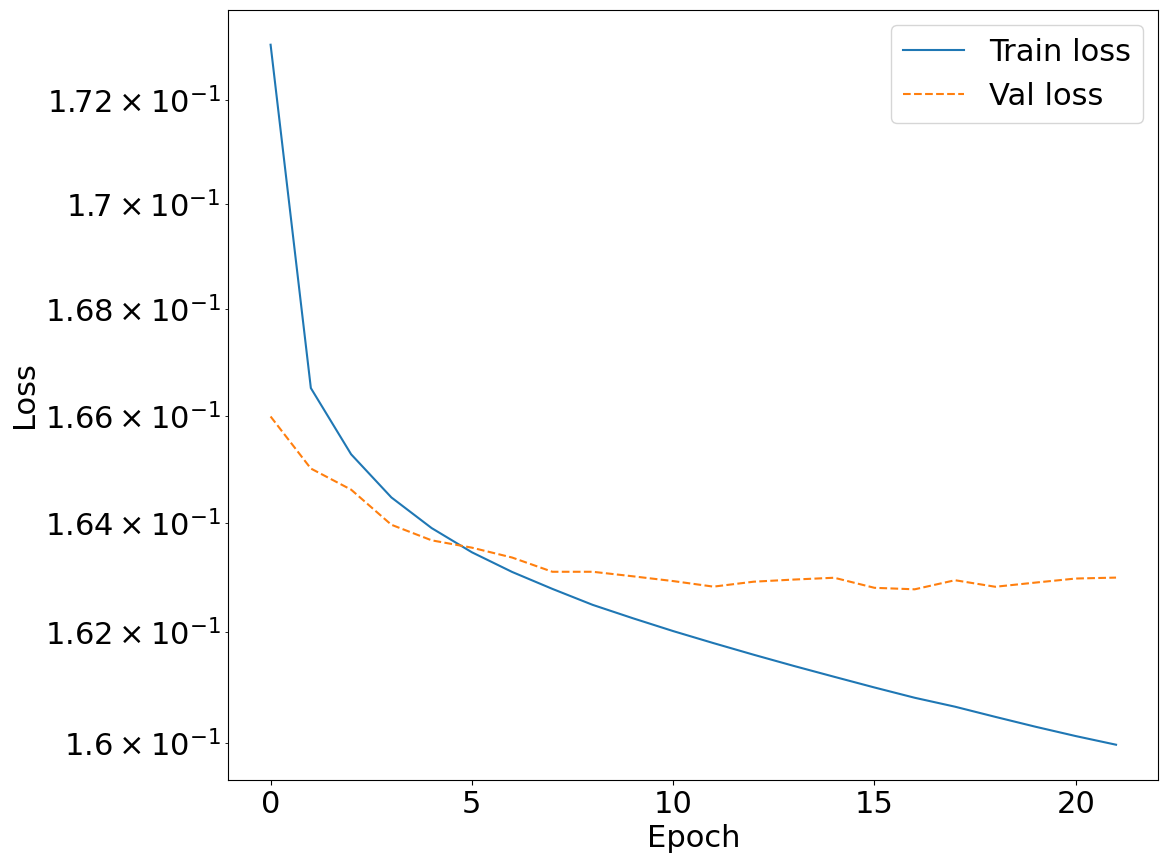

In [37]:
plot_loss(model_history, 'loss', 0)
plt.legend();

### Remove those with target_prior = 1

In [38]:
target_prior_col = [target + '_Prior' for target in target_col[:-1]]
target_proba_col = [target + '_Proba' for target in target_col]

In [39]:
# read data
data_2018 = pd.read_csv(train_file, usecols=['PAT_ID']+target_prior_col, nrows=sample_size)
data_2019 = pd.read_csv(data2019_file, usecols=['PAT_ID']+target_prior_col, nrows=sample_size)
sampled_data = pd.concat([data_2018, data_2019], ignore_index=True).reset_index(drop=True)
del data_2018, data_2019

test = pd.read_csv(test_file, usecols=['PAT_ID']+target_prior_col)
train, val = train_test_split(sampled_data, test_size=val_size, random_state=random_state)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

del sampled_data
gc.collect()

9607

In [40]:
train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions = model.predict(val_features, batch_size=BATCH_SIZE)
test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)

In [41]:
test_max_f1 = create_metrics_df(target_prior_col, target_proba_col,
                                feature_names, target_col, test_features,
                                test_labels, test_predictions, test)
test_max_f1

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.919281,0.30,0.637222,0.857532,0.506974,75737,3728
1,Diabetes_Mellitus,0.948418,0.41,0.847840,0.957370,0.760799,75737,19423
2,Dyslipidaemia,0.963409,0.47,0.899031,0.972210,0.836097,75737,31842
3,Heart_and_Circulatory,0.929395,0.33,0.722769,0.821434,0.645264,75737,9111
4,Hypertension,0.959320,0.46,0.897652,0.990034,0.821039,75737,29403
5,Osteoporosis,0.936389,0.31,0.632768,0.852652,0.503043,75737,3451
6,Renal_Disease,0.941894,0.39,0.775975,0.910211,0.676244,75737,11033
7,Osteoarthritis,0.873029,0.30,0.569273,0.637626,0.514156,75737,9466
8,Deceased,0.922707,0.22,0.451626,0.417587,0.491708,75737,2231


In [42]:
test_max_f1['F1'].mean(), test_max_f1['ROC-AUC'].mean()

(0.7149061779402579, 0.9326490469165982)

In [43]:
test_max_f1 = create_metrics_df(target_prior_col, target_proba_col,
                                feature_names, target_col, test_features,
                                test_labels, test_predictions, test, remove_prior=True)
test_max_f1

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.855534,0.15,0.273023,0.264772,0.281805,74092,2083
1,Diabetes_Mellitus,0.838460,0.23,0.438140,0.441803,0.434537,62516,6202
2,Dyslipidaemia,0.810424,0.21,0.408070,0.309894,0.597299,50041,6146
3,Heart_and_Circulatory,0.872339,0.22,0.468652,0.476983,0.460607,71665,5039
4,Hypertension,0.784134,0.18,0.366100,0.272367,0.558202,51875,5541
5,Osteoporosis,0.879142,0.10,0.237450,0.165703,0.418775,74065,1779
6,Renal_Disease,0.856195,0.19,0.404425,0.341305,0.496187,69162,4458
7,Osteoarthritis,0.817422,0.18,0.392584,0.314333,0.522710,72854,6583
8,Deceased,0.922707,0.22,0.451626,0.417587,0.491708,75737,2231


In [44]:
test_max_f1['F1'].mean(), test_max_f1['ROC-AUC'].mean()

(0.3822301551666622, 0.848484280028982)

#### Evaluate on train set

In [45]:
# train_max_f1 = create_metrics_df(target_prior_col, target_proba_col,
#                                  feature_names, target_col, train_features,
#                                  train_labels, train_predictions, train)
# train_max_f1

In [46]:
# train_max_f1['F1'].mean(), train_max_f1['ROC-AUC'].mean()

In [47]:
train_max_f1 = create_metrics_df(target_prior_col, target_proba_col,
                                 feature_names, target_col, train_features,
                                 train_labels, train_predictions, train, remove_prior=True)
train_max_f1

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.857476,0.14,0.283894,0.256636,0.317630,3431916,99235
1,Diabetes_Mellitus,0.825311,0.21,0.414077,0.354366,0.497990,2887710,296211
2,Dyslipidaemia,0.809997,0.21,0.414928,0.319102,0.593007,2302754,295779
3,Heart_and_Circulatory,0.871806,0.24,0.469559,0.491862,0.449192,3306442,227789
4,Hypertension,0.782472,0.19,0.370213,0.281444,0.540778,2393769,263572
5,Osteoporosis,0.883101,0.12,0.248047,0.190819,0.354307,3424630,84469
6,Renal_Disease,0.856622,0.19,0.400458,0.338472,0.490237,3201261,211971
7,Osteoarthritis,0.821877,0.20,0.401417,0.339971,0.489976,3352189,306703
8,Deceased,0.923466,0.20,0.441095,0.397549,0.495355,3513796,104303


In [48]:
train_max_f1['F1'].mean(), train_max_f1['ROC-AUC'].mean()

(0.38263204185106403, 0.8480142775861353)

#### Evaluate on validation set

In [49]:
# val_max_f1 = create_metrics_df(target_prior_col, target_proba_col,
#                                feature_names, target_col, val_features,
#                                val_labels, val_predictions, val)
# val_max_f1

In [50]:
# val_max_f1['F1'].mean(), val_max_f1['ROC-AUC'].mean()

In [51]:
val_max_f1 = create_metrics_df(target_prior_col, target_proba_col,
                               feature_names, target_col, val_features,
                               val_labels, val_predictions, val, remove_prior=True)
val_max_f1

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.854464,0.14,0.286222,0.265787,0.310060,59383,1819
1,Diabetes_Mellitus,0.823772,0.20,0.416110,0.346251,0.521285,50094,5262
2,Dyslipidaemia,0.804205,0.23,0.411584,0.349355,0.500787,39778,5080
3,Heart_and_Circulatory,0.869512,0.24,0.453060,0.470935,0.436491,57182,3842
4,Hypertension,0.780829,0.19,0.375959,0.287407,0.543379,41466,4599
5,Osteoporosis,0.873000,0.12,0.244418,0.185119,0.359613,59294,1446
6,Renal_Disease,0.851987,0.19,0.389103,0.327162,0.479978,55331,3571
7,Osteoarthritis,0.817420,0.18,0.402408,0.322487,0.534996,58058,5372
8,Deceased,0.921946,0.21,0.419313,0.388703,0.455157,60800,1784


In [52]:
val_max_f1['F1'].mean(), val_max_f1['ROC-AUC'].mean()

(0.3775753166486872, 0.8441260167656319)

## Save Results

In [53]:
def format_df_export(eval_df):
    # drop deceased
    eval_df = eval_df[eval_df['Target']!='Deceased']
    
    # take average
    eval_df.loc['mean'] = eval_df.mean()
    
    return eval_df   

In [54]:
with pd.ExcelWriter(results_folder+f'model_{model_name}.xlsx') as writer:  
    format_df_export(train_max_f1).to_excel(writer, sheet_name='Train')
    format_df_export(val_max_f1).to_excel(writer, sheet_name='Val')
    format_df_export(test_max_f1).to_excel(writer, sheet_name='Test')

## Save Model & Scaler

In [55]:
# !mkdir -p saved_model
model.save(model_folder+'model_{}'.format(model_name))

INFO:tensorflow:Assets written to: ../saved_model/model_final\assets


In [56]:
# Save scaler
dump(scaler, open(model_folder+'scaler_{}.pkl'.format(model_name), 'wb'))

In [57]:
# Save feature names (order matters) # change to csv
pd.DataFrame(feature_names, columns=['Feature name']).to_csv(model_folder+'featurelist_{}.csv'.format(model_name), index=False)

## Generate feature dict for periodic features

In [58]:
# Create time features to aggregate their SHAP impact of the same category together
time_features = [feature.split("_", maxsplit=1)[-1] for feature in feature_names if feature not in non_periodic_features]
time_features = list(set(time_features))
        
features_dict = {}
for feature in time_features:
    features_dict[feature] = [year + feature for year in feature_periods]

In [59]:
# Save feature dict for periodic features
dump(features_dict, open(model_folder+'features_dict_{}.pkl'.format(model_name), 'wb'))

## Generate summarized data using SHAP kmeans

In [60]:
shap_kmeans = shap.kmeans(train_features,10)

In [61]:
# Save summarised data using shap kmeans
dump(shap_kmeans, open(model_folder+'kmeans_{}.pkl'.format(model_name), 'wb'))

In [62]:
gc.collect()

8232